In [14]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

from textblob.sentiments import NaiveBayesAnalyzer

import pandas as pd
import sqlite3
from textblob import TextBlob

import seaborn as sns
sns.set(color_codes=True)

# encoding=utf8
import sys
reload(sys)
sys.setdefaultencoding('utf8')

import spacy
nlp = spacy.load('en')

import re

In [22]:
df = pd.read_csv('../pitchfork.csv')

years = np.arange(1999, 2018)
df_new = df[df['new_album'] == 1]
df_reissue = df[df['new_album'] == 0]

In [38]:
df_spotify = pd.read_csv('spotify_with_rank.csv')

df_merged = df.merge(df_spotify, how='left', on=['artist', 'title'])

## Analysis of the Spread of Scores

In [23]:
less3 = list(df_new[df_new['score'] <= 3].groupby('pub_year').count()['reviewid'] / (df_new.groupby('pub_year')['reviewid'].count().astype(float)))
less6 = list(df_new[df_new['score'] <= 6].groupby('pub_year').count()['reviewid'] / (df_new.groupby('pub_year')['reviewid'].count().astype(float)))
more9 = list(df_new[df_new['score'] >= 9].groupby('pub_year').count()['reviewid'] / (df_new.groupby('pub_year')['reviewid'].count().astype(float)))
reis_more9 = list(df_reissue[df_reissue['score'] >= 9].groupby('pub_year').count()['reviewid'] / (df_reissue.groupby('pub_year')['reviewid'].count().astype(float)))

Pitchfork has sharply decreased its frequency of giving scathing reviews. Following are several visuals showing how Pitchfork has gotten more 'vanilla' over the years.

Pitchfork almost never gives out reviews below a 3, when previously it was pretty common. In 'the old days' of Pitchfork, reviews had an edge, where they felt targeting and malicious. Here's a link to a particularly scathing review of Liz Phair's album 'Liz Phair':

https://pitchfork.com/reviews/albums/6255-liz-phair/

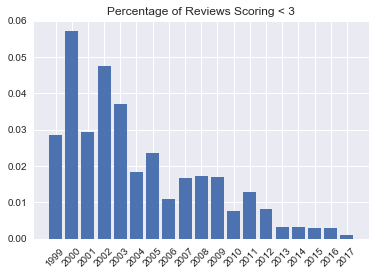

In [24]:
plt.bar(years, less3)
plt.xticks(years, range(1999, 2018),rotation =45)
plt.title("Percentage of Reviews Scoring < 3")
plt.show()

It's becoming more rare to see albums scoring below a 6. Nearly 90% of reviews in 2017 were 6+. Pitchfork has all but abandoned giving negative reviews to albums. Taylor Swift, who previously had never been reviewed before, managed to score a 6.5 in 2017 -- just a few points lower than the critics average on metacritic.

http://www.metacritic.com/music/reputation/taylor-swift/critic-reviews

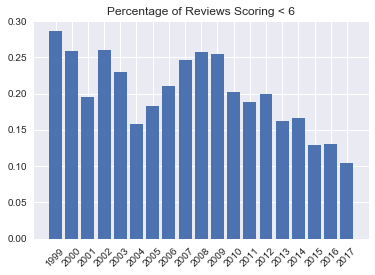

In [25]:
plt.bar(years, less6)
plt.xticks(years, range(1999, 2018),rotation =45)
plt.title("Percentage of Reviews Scoring < 6")

plt.show()

Albums scoring above 9 are still a rare commodity. Since "Best New Music" launched in 2003, 9+ has been sacred space for Pitchfork reviews of new releases.

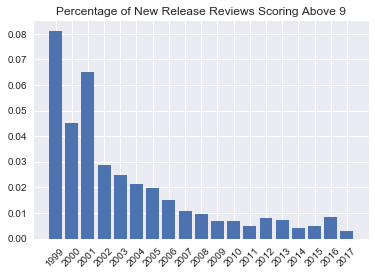

In [26]:
plt.bar(years, more9)
plt.xticks(years, range(1999, 2018),rotation =45)
plt.title("Percentage of New Release Reviews Scoring Above 9")

plt.show()

However, Pitchfork has become more conservative when scoring an artist's first or second majore release. Pitchfork was known for launching the careers of many bands, including Arcade Fire, whose album "Funeral" received a 9.7 in 2004, and Bon Iver, whose album "For Emma, Forever Ago" from 2007 put them on the map. In recent years, there has been a sharp decline in the frequency of new artists receiving scores above 9.0.

## The spread of scores is shrinking

With each major business launch, Pitchfork editors have narrowed the band of score they give throughout the year.

Since 1999, Pitchfork has always scored most of their albums between 6 and 9. But take a look at how the tails have shrunk over time.

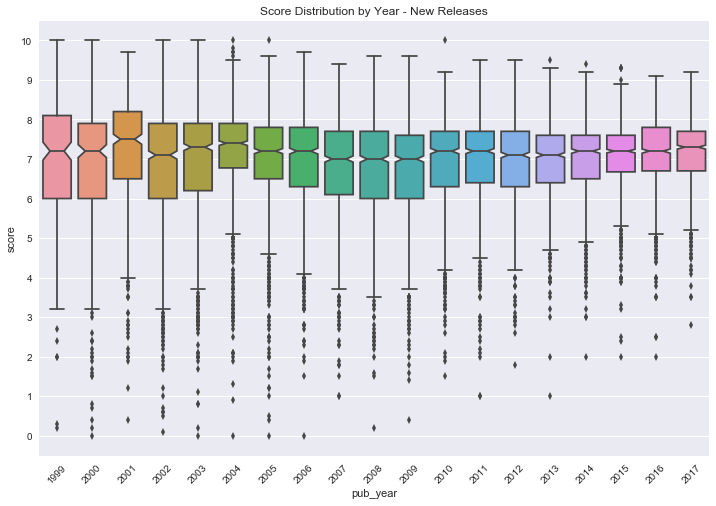

In [27]:
plt.figure(figsize=(12,8))

sns.boxplot(x=df_new['pub_year'], y=df_new['score'], data=df_new[['score', 'pub_year']], notch=True)
plt.title('Score Distribution by Year - New Releases')
plt.yticks(np.arange(0,11))

plt.xticks(rotation=45)
plt.show()

Zooming in on the inner quartiles while also binning years for important eras in Pitchfork's history shows the movement of the median score. In the following chart, the notches indicate a 95% condifidence interval for the median. Since the acquisition by Conde Nast, the median score has significantly risen when comparing to the median score for 2011-2015.

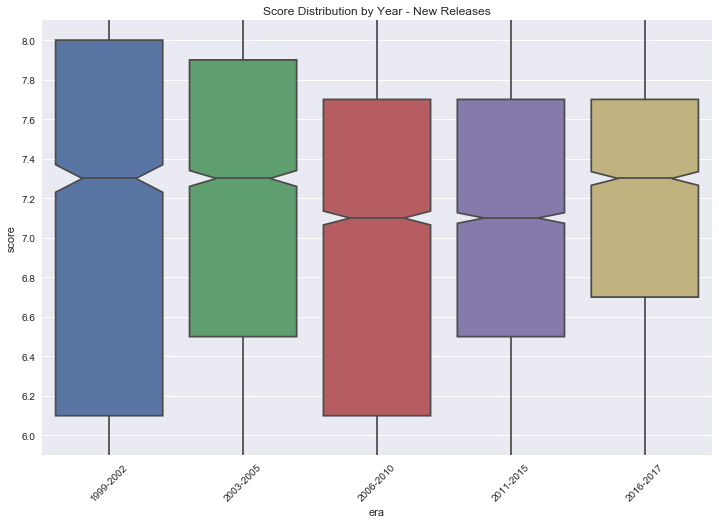

In [34]:
plt.figure(figsize=(12,8))
medians = df_new.groupby(['era'])['score'].median().values
median_labels = [str(np.round(s, 2)) for s in medians]
sns.boxplot(x=df_new['era'][::-1], y=df_new['score'], data=df_new[['score', 'era']], notch=True)
plt.title('Score Distribution by Year - New Releases')
plt.yticks(np.arange(0,11, .2))
plt.ylim(5.9, 8.1)
plt.xticks(rotation=45)
plt.show()

Here's another way to look at it by era. Notice how the spread decreases during the recent eras.

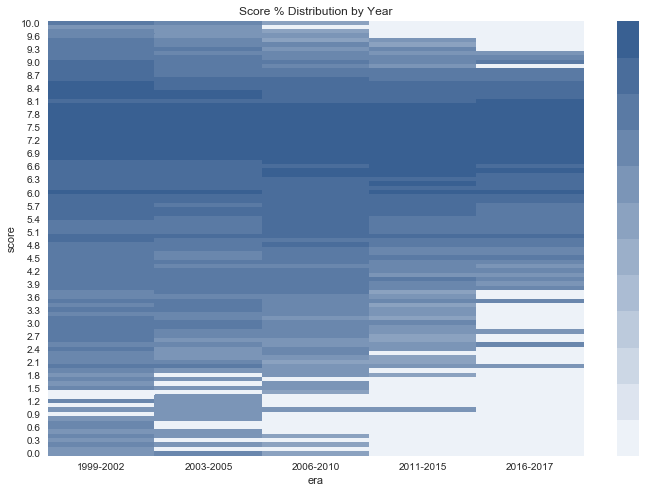

In [35]:
temp_df = pd.DataFrame(df_new.groupby(['era', 'score'])['reviewid'].count()).reset_index()
heatmap_df = temp_df.pivot(index='score', columns='era', values='reviewid').fillna(.001)
df_norm_col=(heatmap_df)/heatmap_df.sum()

plt.figure(figsize=(12,8))
plt.title("Score % Distribution by Year")
plt.xlabel('Year')

plt.ylabel('Score')
sns.heatmap(df_norm_col[::-1], 
#             annot=(df_norm_col[::-1]).round(3), 
            norm=LogNorm(vmin=0, vmax=1), 
            fmt='.1%', 
            cmap=sns.light_palette((250, 70, 40), input='husl', n_colors=12)
           )
plt.show()

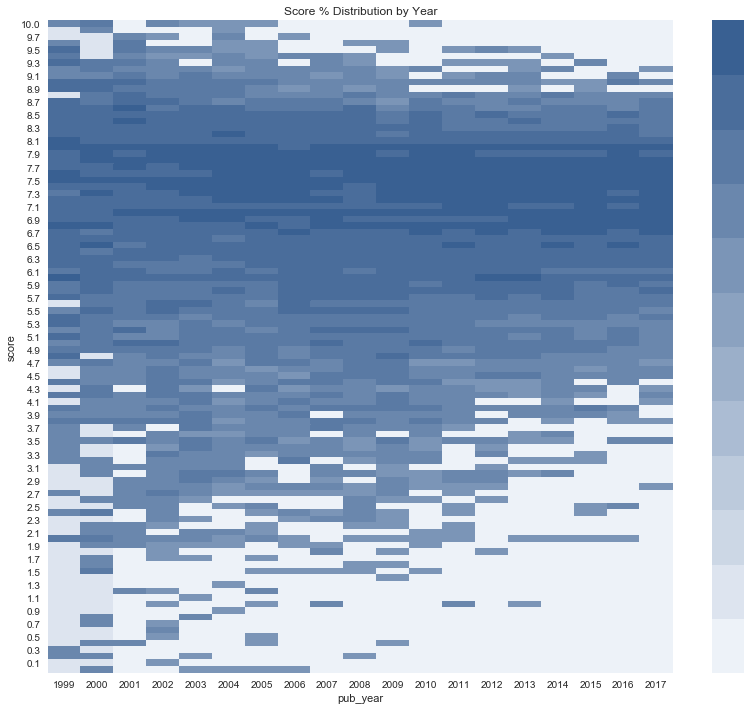

In [29]:
temp_df = pd.DataFrame(df_new.groupby(['pub_year', 'score'])['reviewid'].count()).reset_index()
heatmap_df = temp_df.pivot(index='score', columns='pub_year', values='reviewid').fillna(.001)
df_norm_col=(heatmap_df)/heatmap_df.sum()

plt.figure(figsize=(14,12))
plt.title("Score % Distribution by Year")
plt.xlabel('Year')

plt.ylabel('Score')
sns.heatmap(df_norm_col[::-1], 
#             annot=(df_norm_col[::-1]).round(3), 
            norm=LogNorm(vmin=0, vmax=1), 
            fmt='.1%', 
            cmap=sns.light_palette((250, 70, 40), input='husl', n_colors=12)
           )
plt.show()

In [43]:
# score_by_year = df_new.groupby('pub_year').agg(['mean', 'max','min','count','sum']).reset_index()

# score_by_year['percent_bnm'] = score_by_year['best_new_music']['sum'] / score_by_year['score']['count']

# plt.plot(score_by_year['pub_year'][4:19], score_by_year['percent_bnm'][4:19])
# plt.title('Best New Music Frequency')
# plt.xticks(score_by_year['pub_year'][4:19], rotation=45)
# plt.yticks()
# plt.xlabel('Year')
# plt.ylabel('% of Albums Named Best New Music')
# plt.show()